<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Анализ-по-часам" data-toc-modified-id="Анализ-по-часам-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ по часам</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Dummy" data-toc-modified-id="Dummy-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Dummy</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV

from catboost import CatBoostRegressor

In [ ]:
data_source = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data_source.sort_index(inplace=True)
data = data_source.resample('1H').sum()

In [ ]:
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Анализ

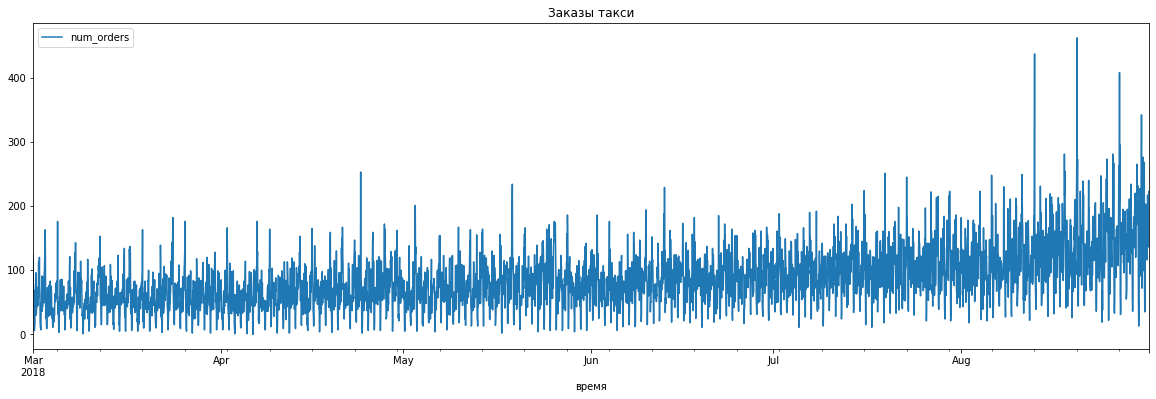

In [ ]:
data.plot(xlabel='время',y=['num_orders'])
plt.title('Заказы такси')
plt.show()

In [ ]:
data_1d = data_source.resample('1D').sum()

### Анализ по часам

In [ ]:
decomposed = seasonal_decompose(data['num_orders'])

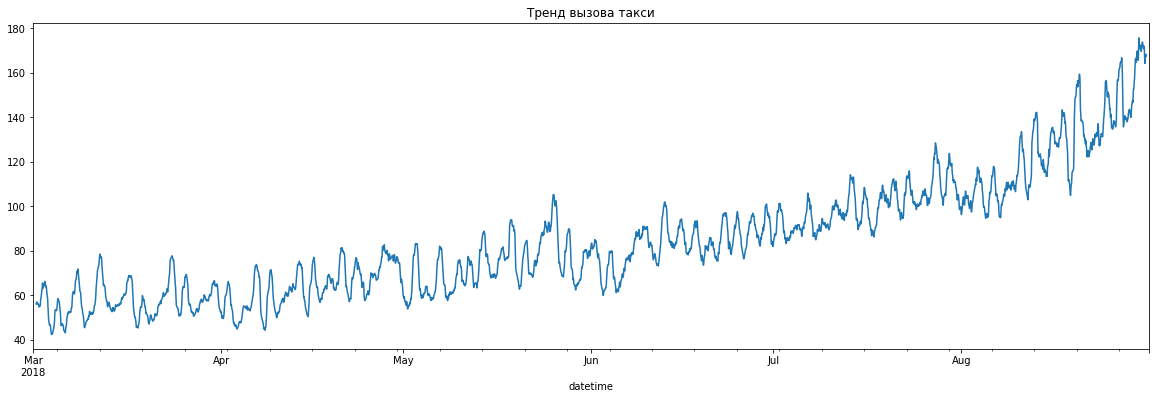

In [ ]:
decomposed.trend.plot()
plt.title('Тренд вызова такси')
plt.show()

Из графика видно, что есть тренд. Начиная с августа тренд ускоряется.

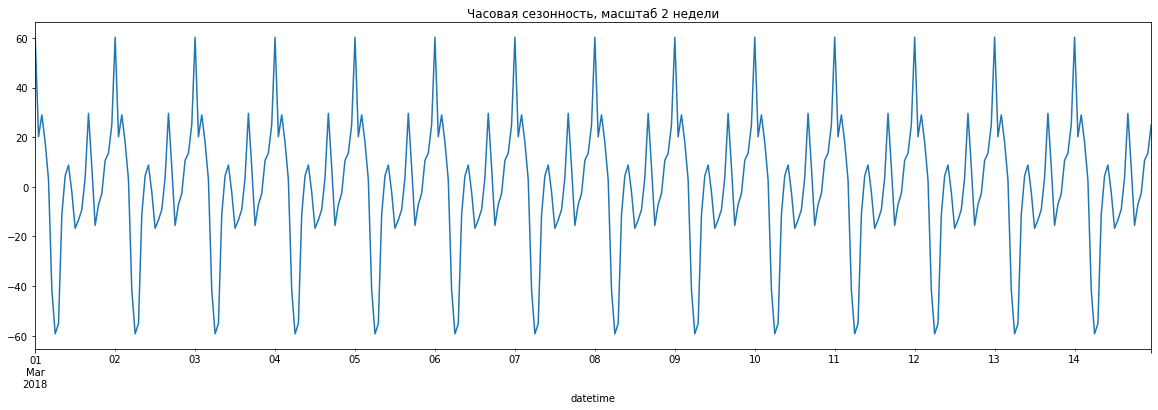

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-14'].plot()
plt.title('Часовая сезонность, масштаб 2 недели')
plt.show()

Из графика видно, что есть часова сезонность, которая повторяется каждый день

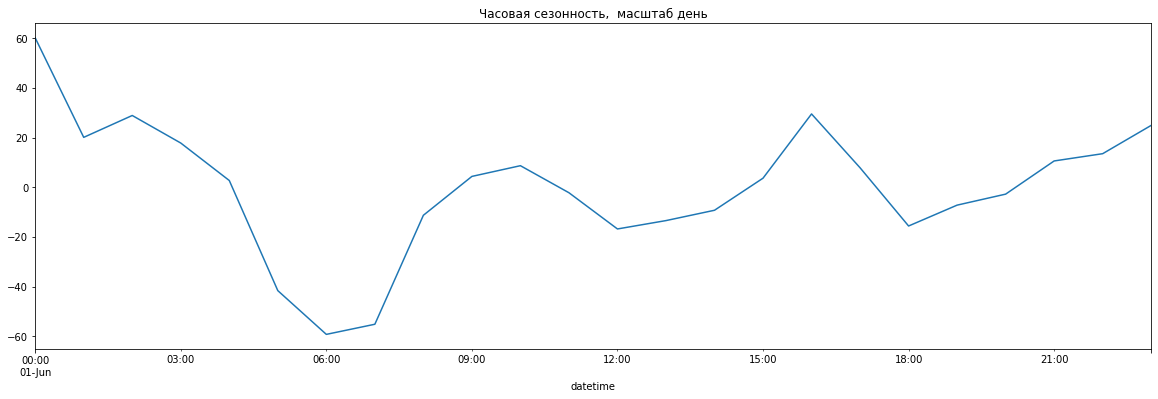

In [ ]:
decomposed.seasonal['2018-06-01':'2018-06-01'].plot()
plt.title('Часовая сезонность,  масштаб день')
plt.show()

- Максимальное число вызовов такси: 00:00
- До 4 утра большой спрос
- Так же большой спрос в утренние часы с 8:00 до 10:00
- Второй пик в 16:00

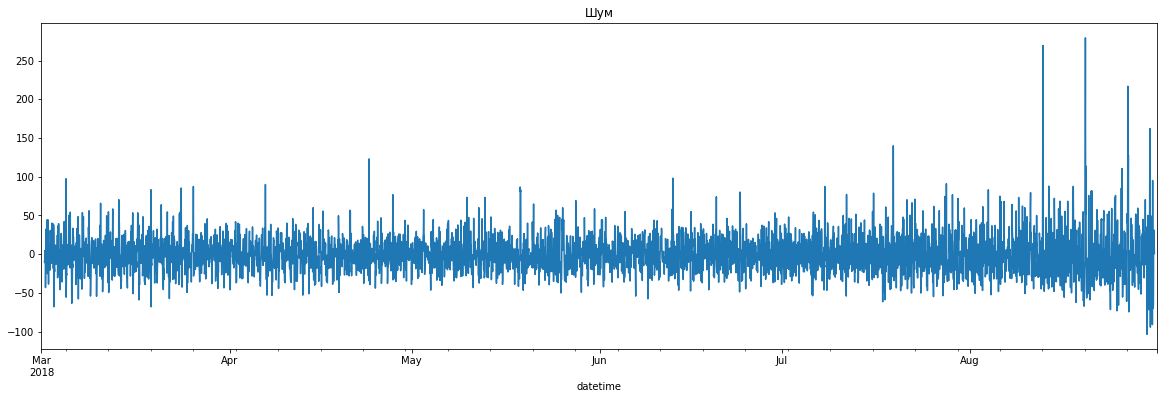

In [ ]:
decomposed.resid.plot()
plt.title('Шум')
plt.show()

Шум возврастает к концу периода в августе. Это может негативно повлияет на предсказания модели.

In [ ]:
decomposed_1d = seasonal_decompose(data_1d['num_orders'])

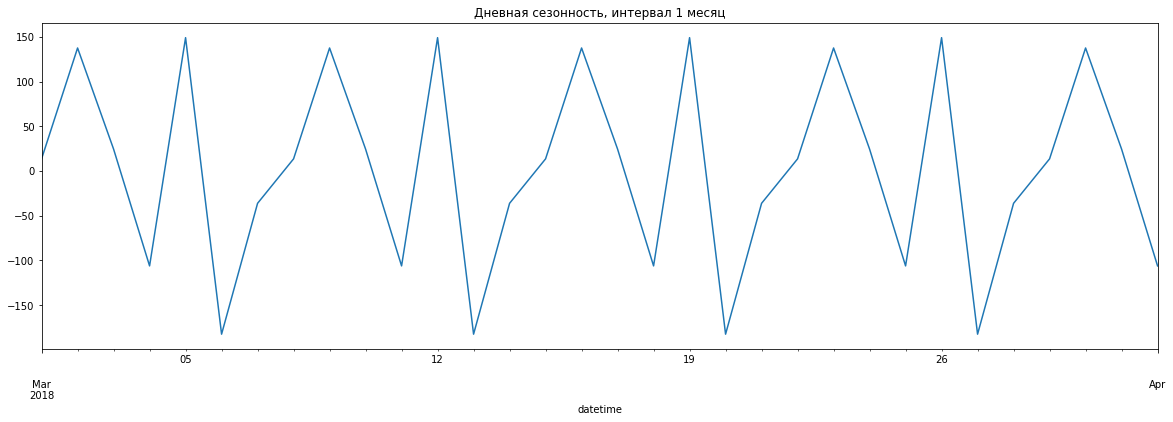

In [ ]:
decomposed_1d.seasonal['2018-03-01':'2018-04-01'].plot()
plt.title('Дневная сезонность, интервал 1 месяц')
plt.show()



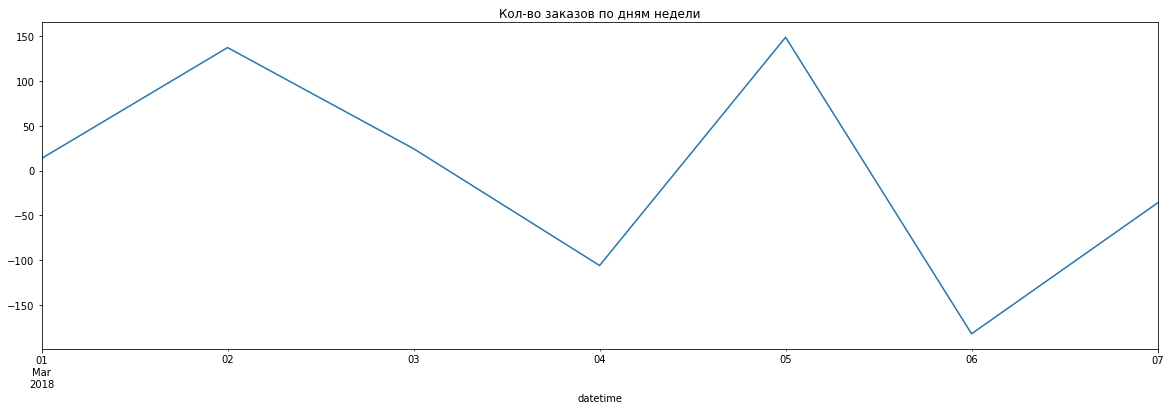

In [ ]:
decomposed_1d.seasonal['2018-03-01':'2018-03-07'].plot()
plt.title('Кол-во заказов по дням недели')
plt.show()

- дневная сезонность так же присутствует
- максимальное количество заказов по пятницам, понедельникам
- минимальное кол-во по четвергам и вторникам


### Проверим на стационарность наш ряд с помощью метода ad fuller

In [ ]:
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


In [ ]:
data = data.dropna()

### Вывод

- Мы проанализировали временной ряд на тренд, сезонность и стационарность.
- Временной ряд:
    - стационарным
    - имеет сезонность в течение дня.
    - имеет сезонность по дням недели

## Обучение

Рассчитаем новые признаки:

In [ ]:
def make_features(data, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    #data['minute'] = data.index.minute

    for lag in range(1, 7+1):
        data['lag_{}d_0'.format(lag)] = data['num_orders'].shift(lag * 24) #тот же час сегодня, день назад и тд.
        data['lag_{}d_1'.format(lag)] = data['num_orders'].shift(lag * 25) #-1 час сегодня, день назад и тд.

    for lag in range(1, 23 + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

In [ ]:
make_features(data, 6)

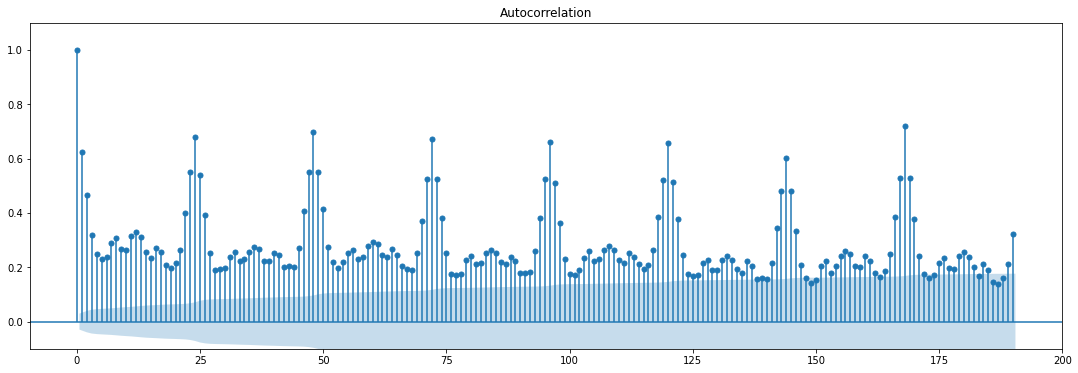

In [ ]:
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

In [ ]:
data = data.dropna()

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train_features = train.drop(columns='num_orders')
train_target = train['num_orders']

test_features = test.drop(columns='num_orders')
test_target = test['num_orders']

### LinearRegression

In [ ]:
model = LinearRegression()

model.fit(train_features, train_target)

LinearRegression()

In [ ]:
tscv = TimeSeriesSplit(n_splits=24)

In [ ]:
print('RMSE:',cross_val_score(estimator=model, X=train_features, y=train_target, cv=tscv, scoring='neg_root_mean_squared_error').mean())

RMSE: -21.724058104948895


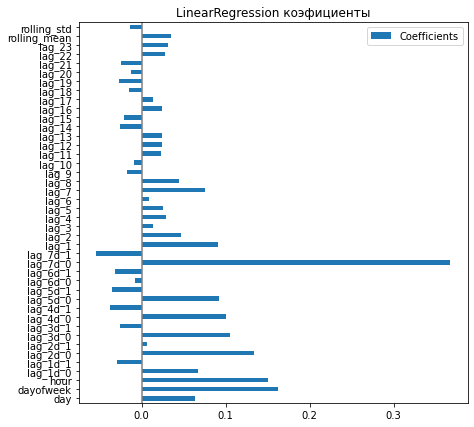

In [ ]:
coefs = pd.DataFrame(
    model.coef_, columns=["Coefficients"], index=train_features.columns
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("LinearRegression коэфициенты")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

### CatBoostRegressor

In [ ]:
params = {
    "iterations": [200,400,700],
    "depth": [1,2,4,6],
    "learning_rate": [0.1, 0.2]
}

In [ ]:
model_cb = CatBoostRegressor(loss_function='RMSE', random_state=12345)

In [ ]:
grid_search_result = model_cb.grid_search(param_grid=params,
                                X=train_features,
                                y=train_target,
                                cv=tscv,
                                search_by_train_test_split=True,
                                shuffle=False,
                                plot=True
                               )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 73.6249476	test: 108.6701764	best: 108.6701764 (0)	total: 47.7ms	remaining: 9.49s
1:	learn: 67.4965099	test: 101.3587256	best: 101.3587256 (1)	total: 48.8ms	remaining: 4.83s
2:	learn: 62.0714849	test: 95.5840942	best: 95.5840942 (2)	total: 49.7ms	remaining: 3.26s
3:	learn: 57.1006205	test: 89.1216916	best: 89.1216916 (3)	total: 50.6ms	remaining: 2.48s
4:	learn: 52.7281744	test: 84.0956170	best: 84.0956170 (4)	total: 51.5ms	remaining: 2.01s
5:	learn: 48.7741757	test: 79.1894952	best: 79.1894952 (5)	total: 52.3ms	remaining: 1.69s
6:	learn: 45.2921896	test: 75.0627890	best: 75.0627890 (6)	total: 53.1ms	remaining: 1.47s
7:	learn: 42.2565609	test: 71.1475683	best: 71.1475683 (7)	total: 54ms	remaining: 1.3s
8:	learn: 39.6330811	test: 68.0101707	best: 68.0101707 (8)	total: 54.9ms	remaining: 1.16s
9:	learn: 37.2675584	test: 64.3149097	best: 64.3149097 (9)	total: 55.7ms	remaining: 1.06s
10:	learn: 35.2148427	test: 61.8219854	best: 61.8219854 (10)	total: 56.5ms	remaining: 971ms
11:	lea

In [ ]:
importances=model_cb.get_feature_importance()

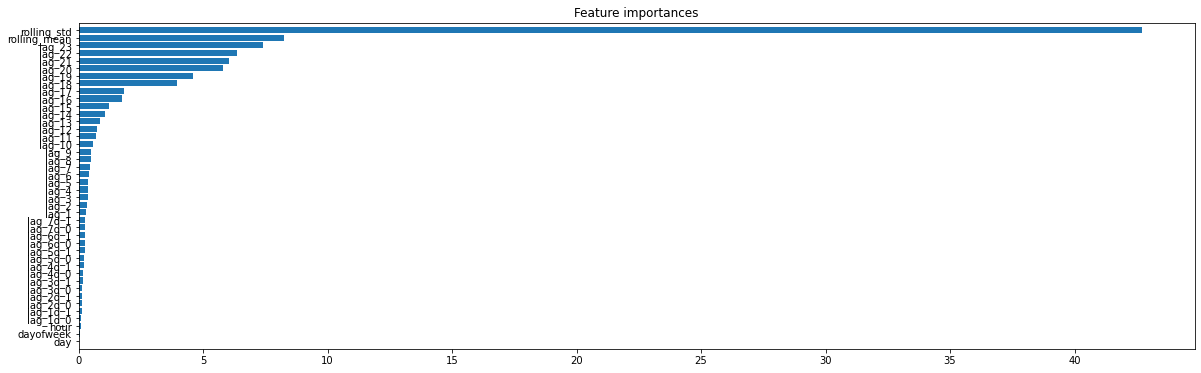

In [ ]:
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(train_features.shape[1]), importances[indices], align="center")
plt.yticks(range(train_features.shape[1]), train_features.columns)
plt.ylim([-1, train_features.shape[1]])
plt.show()

In [ ]:
model_cb.fit(train_features, train_target)

0:	learn: 35.4888336	total: 2.09ms	remaining: 416ms
1:	learn: 32.8793882	total: 3.82ms	remaining: 378ms
2:	learn: 30.6556228	total: 5.4ms	remaining: 355ms
3:	learn: 28.9785851	total: 6.95ms	remaining: 340ms
4:	learn: 27.6069747	total: 8.6ms	remaining: 335ms
5:	learn: 26.4225425	total: 10.2ms	remaining: 329ms
6:	learn: 25.5555496	total: 11.7ms	remaining: 324ms
7:	learn: 24.8372781	total: 13.2ms	remaining: 318ms
8:	learn: 24.1906124	total: 14.8ms	remaining: 314ms
9:	learn: 23.7213391	total: 16.3ms	remaining: 310ms
10:	learn: 23.3188153	total: 17.9ms	remaining: 307ms
11:	learn: 23.0177649	total: 19.4ms	remaining: 303ms
12:	learn: 22.7077382	total: 20.9ms	remaining: 301ms
13:	learn: 22.4864932	total: 22.3ms	remaining: 297ms
14:	learn: 22.2926144	total: 23.9ms	remaining: 294ms
15:	learn: 22.1682205	total: 25.4ms	remaining: 293ms
16:	learn: 22.0536710	total: 26.9ms	remaining: 290ms
17:	learn: 21.9986964	total: 28.4ms	remaining: 287ms
18:	learn: 21.9489800	total: 29.8ms	remaining: 284ms
19:	l

## Тестирование

### LinearRegression

In [ ]:
train_predict = model.predict(train_features)
test_predict = model.predict(test_features)

In [ ]:
print("RMSE обучающей выборки:", mean_squared_error(train_target, train_predict, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(test_target, test_predict, squared=False))

RMSE обучающей выборки: 21.13451252439396
RMSE тестовой выборки: 34.2397231280932


### CatBoostRegressor

In [ ]:
train_predict_cb = model_cb.predict(train_features)
test_predict_cb = model_cb.predict(test_features)

In [ ]:
print("RMSE обучающей выборки:", mean_squared_error(train_target, train_predict_cb, squared=False))
print("RMSE тестовой выборки:", mean_squared_error(test_target, test_predict_cb, squared=False))

RMSE обучающей выборки: 18.592219245923054
RMSE тестовой выборки: 40.74357752034919


### Dummy

In [ ]:
pred_previous = test_target.shift()
pred_previous.iloc[0] = train_target.iloc[-1]

In [ ]:
print("RMSE тестовой выборки:", mean_squared_error(test_target, pred_previous, squared=False))

RMSE тестовой выборки: 58.819724582830204


## Вывод

В задаче необходимо было построить модель для предсказания загруженности такси на следующий час. Значение RMSE должно быть меньше 48.

Мы изучили данные-временной ряд заказов такси:
- сделали ресемплирование по каждому часу
- проанализировали характеристики временного ряда
    
Построили 2 модели:
- Логистическая регрессия
- Модель регресии с помощью градиентного бустинга библиотеки CatBoost
    
Лучшая модель:
- LinearRegression
- RMSE 21.13451252439396